In [3]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import random
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
crs = {'init': 'epsg:4326'}


Pour la suite des projections, on utiliseras la carte des zones des zones de taxi.
Elle est disponible en format shapefile à l'adresse suivante: https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip.

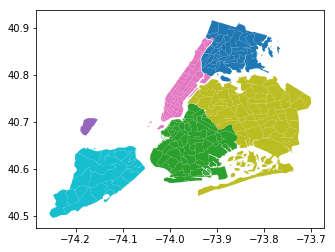

In [11]:
taxizones = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/taxi_zones.shp'
df_taxizones=gpd.read_file(taxizones).to_crs(crs)
df_taxizones.plot(column='borough', categorical=True)

# 1- Construction de la base de donnée

On va collecter des informations sur les bases de données disponibles sur le site open data de la ville de new york pour tenter de localiser des éléments particuliers (universités, cimetieres, lieux de culte, écoles...) pouvant nous donner une indication sur les caractérisqtiues socio-économiques du lieu de prise en charge, des passagers et sur le contexte de leurs courses.
Nous voulions au debut des valeurs plus économiques, cependant il nous était impossible d'extraire le PIB par habitant, le nombre de siege d'entreprise, le tax de chomage etc avec une granularité suffisamment importante pour être intéressant.
Nous avons tenté de palier à l'inaccès aux données sur les bars, cafés, restaurants etc en intégrant une analyse temporelle, détaillée dans la partie suivante.

##    a- Extraction des positions géographiques des lieux d'intérêt

Lorsque les données étaient déjà données sous forme de shapefile, les dataframe obtenus en les lisant étaient déjà des geoDtataFrame avec une variable géometrique nous donnant la position du lieu.

Les collèges et universités nous ont semblé intéressant dans notre regression car ils attrent un grand nombre de personnes. Parmi les personnes partant d'un lieu à proximité d'un tel lieu, on peut s'attendre à voir des étudiants fortuunés (puisqu'ils se permettent de payer un taxi en plus de leur frais de scolarité), des professeurs et des conférenciers, appartenant eux aussi généralement à la classe éonomique supérieure.
On remarque que bien qu'un très grand nombre soit situé sur Manhattan, ils sont tout de même présents sur les autres quartiers.

In [27]:
## college & universities
# load data
college = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/original_collegeanduniversity.shp'
df_college = gpd.read_file(college).to_crs(crs)

<class 'geopandas.geodataframe.GeoDataFrame'>


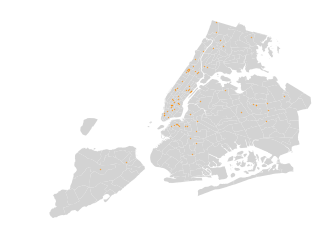

In [116]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_college.plot(ax=ax, markersize=0.1, color='darkorange')
print(type(df_college))

Nous nous sommes également intéressées aux entrées de métro. Nous avons en effet pensé que si une personne se trouve à proximité d'un grand nombre de stations de métro mais qu'elle prend le taxi, c'est que le oût économique de prendre un taxi lui semble moins important que le désagrement de prendre le métro bien qu'il soit tout proche.
Nous avons pris le nombre d'entrées et non de stations car plus il y a un grand nombre d'entrées dans une station plus celle-ci est importante et donc intéressante en terme de mobilité pour le voyageur potentiel (nombre de lignes, lignes centrales).
Ainsi, si le voyageur qui préfère le taxi au métro lorsqu'un grand nombre de bouches de métro sont à proximité, on peut s'attendre à ce qu'il ait un fort pouvoir économique et plus enclin à laisser un gros pourboire car plus indolore économiquement pour lui. 

In [12]:
#subway entrances
subway = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/subway_entrances.shp'
df_subway=gpd.read_file(subway).to_crs(crs)

<class 'geopandas.geodataframe.GeoDataFrame'>


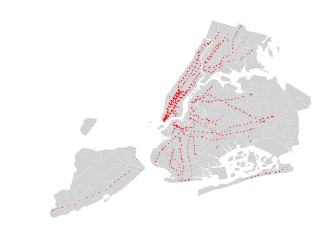

In [25]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_subway.plot(ax=ax, markersize=0.01, color='red')
print(type(df_subway))

In [28]:

## health facilities
#load data
hospital = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/original_hospitals.csv'
df_hospital = pd.read_csv(hospital, sep=";")
#extract long and lat from location 1 column in the df 
df_hospital['position'] = df_hospital['Location 1'].str.replace(r'[^(]*\(|\)[^)]*', '')
df_hospital['newlongitude'] = df_hospital['position'].str.replace(r'[^,]*\,', '')
df_hospital['newlatitude']= df_hospital['position'].str.replace(r'\,[^,]*', '')
#convert them as a float and then as geo points to build the specific column
df_hospital['newlatitude'] = df_hospital['newlatitude'].astype(float)
df_hospital['newlongitude'] = df_hospital['newlongitude'].astype(float)
df_hospital['geometry'] = gpd.GeoSeries([Point(xy) for xy in zip(df_hospital.newlongitude, df_hospital.newlatitude)])
geodf_hospital = gpd.GeoDataFrame(df_hospital,crs=crs)
geodf_hospital = geodf_hospital.set_geometry("geometry")

<class 'geopandas.geodataframe.GeoDataFrame'>


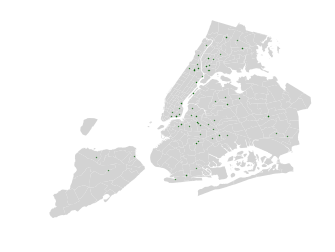

In [48]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
geodf_hospital.plot(ax=ax, markersize=0.1, color='darkgreen')
print(type(geodf_hospital))

In [30]:

##Points of Interest
#load data
PoI = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/original_PointOfInterest.shp'
df_PoI = gpd.read_file(PoI).to_crs(crs)

In [31]:
 #recensement des abréviations
ab_religion = pd.Series(['religion','CATHEDRAL','SYNAGOGUE','EPISCOPAL', 'TEMPLE', 'CHUR','TMPL','TABERNACLE',' CH ', 'CATHDL', 'CHAPEL','CONGREGAT','CONGEGRATION', 'EVANGICAL LUTH','ISRAEL'])
ab_consulate = pd.Series(['consulate','CONSULATE'])
ab_park= pd.Series(['park','PARK','PLGD','PLAYGROUND', 'PLAYGRND', 'RECREATION', 'SQUARE', 'GARDEN'])
ab_theatre = pd.Series(['theatre','THEATRE', 'THTR'])
ab_school = pd.Series(['school','HS','HIGH SCHOOL', 'SCHL', ' SC ','SCHOOL','ACADEMY'])
ab_library = pd.Series(['library','LIBRARY'])
ab_daycare = pd.Series(['daycare','DAY CARE','DAYCARE','NURSERY','NURSING','NURSIG'])
ab_cemetery = pd.Series (['cemetry','CEMETERY','CMTRY'])


In [32]:
#on vire les nan de la colonne name car impossible de les catégoriser
df_PoI=df_PoI.dropna(subset=['name'])
df_PoI.reset_index(drop=True, inplace=True)

In [33]:
# Création des dummy variables
j=0
df_PoI['dum_religion']=0
df_PoI['dum_consulate']=0
df_PoI['dum_park']=0
df_PoI['dum_theatre']=0
df_PoI['dum_school']=0
df_PoI['dum_library']=0
df_PoI['dum_daycare']=0
df_PoI['dum_cemetery']=0

In [34]:

#we create dummy variables to classify the points of interest


while j < (df_PoI.shape[0] - 1) :
    i=0
    while ( i < ab_religion.size and df_PoI.loc[j,'dum_religion']==0 ):
            if ab_religion.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_religion', 1)
 #         print('On recherche ', i,' dans ', j, '. Limit is ', ab_religion.size)
            i+=1    
     
    i=0
    while ( i < ab_consulate.size and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
            if ab_consulate.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_consulate', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_consulate.size)
            i+=1           
          
    i=0 
    while ( i < ab_park.size and df_PoI.loc[j,'dum_park']==0and df_PoI.loc[j,'dum_consulate']==0  and df_PoI.loc[j,'dum_religion']==0 ):
            if ab_park.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_park', 1)
 #         print('On recherche ', i,' dans ', j, '. Limit is ', ab_park.size)
            i+=1
    
    i=0 
    while ( i < ab_theatre.size and df_PoI.loc[j,'dum_theatre']==0 and df_PoI.loc[j,'dum_park']==0 and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
          if ab_theatre.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_theatre', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_theatre.size)
          i+=1
          
    i=0
    while ( i < ab_school.size and df_PoI.loc[j,'dum_school']==0 and df_PoI.loc[j,'dum_theatre']==0and df_PoI.loc[j,'dum_park']==0 and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
          if ab_school.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_school', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_school.size)
          i+=1


    i=0 
    while ( i < ab_library.size and df_PoI.loc[j,'dum_library']==0 and df_PoI.loc[j,'dum_school']==0 and df_PoI.loc[j,'dum_theatre']==0and df_PoI.loc[j,'dum_park']==0and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
          if ab_library.loc[i] in df_PoI.loc[j,'name']:
                df_PoI.set_value(j,'dum_library', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_library.size)
          i+=1
          
    i=0 
    while ( i < ab_daycare.size and df_PoI.loc[j,'dum_daycare']==0 and df_PoI.loc[j,'dum_library']==0 and df_PoI.loc[j,'dum_school']==0 and df_PoI.loc[j,'dum_theatre']==0 and df_PoI.loc[j,'dum_park']==0 and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
        if ab_daycare.loc[i] in df_PoI.loc[j,'name']:
            df_PoI.set_value(j,'dum_daycare', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_daycare.size)
        i+=1          
          
          
    i=0 
    while ( i < ab_cemetery.size and df_PoI.loc[j,'dum_cemetery']==0 and df_PoI.loc[j,'dum_daycare']==0 and df_PoI.loc[j,'dum_library']==0 and df_PoI.loc[j,'dum_school']==0 and df_PoI.loc[j,'dum_theatre']==0and df_PoI.loc[j,'dum_park']==0and df_PoI.loc[j,'dum_consulate']==0 and df_PoI.loc[j,'dum_religion']==0 ):
        if ab_cemetery.loc[i] in df_PoI.loc[j,'name']:
            df_PoI.set_value(j,'dum_cemetery', 1)
#          print('On recherche ', i,' dans ', j, '. Limit is ', ab_cemetery.size)
        i+=1          
          
    j+=1
     


In [35]:
#lieux de culte
df_religion=df_PoI[df_PoI.dum_religion!=0]
df_religion.reset_index(drop=True, inplace=True)
col_religion = gpd.GeoSeries(df_religion.geometry)
col_religion.head()

0    POINT (-73.93634786975662 40.68091615244033)
1    POINT (-73.93569488141881 40.75255340482011)
2    POINT (-73.91828483362288 40.65080302570205)
3    POINT (-74.00674292455398 40.62742678200225)
4    POINT (-73.94597769590463 40.80647201947438)
Name: geometry, dtype: object

<class 'geopandas.geodataframe.GeoDataFrame'>


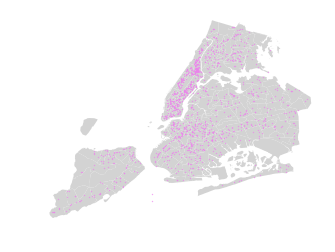

In [38]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_religion.plot(ax=ax, markersize=0.1, color='violet')
print(type(df_religion))

In [39]:
#consulate
df_consulate=df_PoI[df_PoI.dum_consulate!=0]
df_consulate.reset_index(drop=True, inplace=True)

<class 'geopandas.geodataframe.GeoDataFrame'>


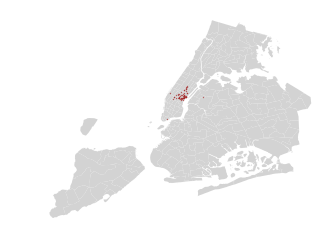

In [40]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_consulate.plot(ax=ax, markersize=0.1, color='brown')
print(type(df_consulate))

In [41]:
#park
df_park=df_PoI[df_PoI.dum_park!=0]
df_park.reset_index(drop=True, inplace=True)

<class 'geopandas.geodataframe.GeoDataFrame'>


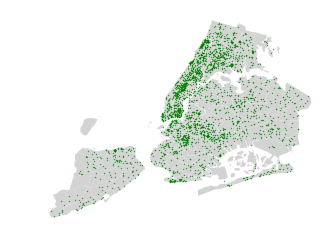

In [42]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_park.plot(ax=ax, markersize=0.1, color='green')
print(type(df_park))

In [43]:
#theatre
df_theatre=df_PoI[df_PoI.dum_theatre!=0]
df_theatre.reset_index(drop=True, inplace=True)

<class 'geopandas.geodataframe.GeoDataFrame'>


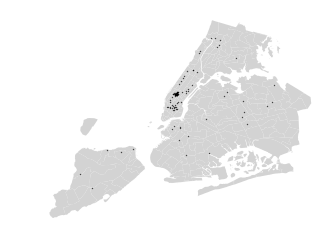

In [47]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_theatre.plot(ax=ax, markersize=0.1, color='black')
print(type(df_theatre))

In [45]:
#school
df_school=df_PoI[df_PoI.dum_school!=0]
df_school.reset_index(drop=True, inplace=True)

<class 'geopandas.geodataframe.GeoDataFrame'>


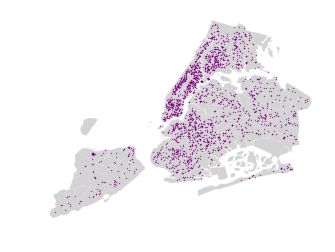

In [50]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_school.plot(ax=ax, markersize=0.1, color='purple')
print(type(df_school))

In [57]:
#library
df_library=df_PoI[df_PoI.dum_library!=0]
df_library.reset_index(drop=True, inplace=True)

<class 'geopandas.geodataframe.GeoDataFrame'>


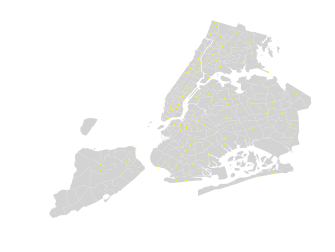

In [62]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_library.plot(ax=ax, markersize=0.1, color='yellow')
print(type(df_library))

In [63]:
#daycare
df_daycare=df_PoI[df_PoI.dum_daycare!=0]
df_daycare.reset_index(drop=True, inplace=True)

<class 'geopandas.geodataframe.GeoDataFrame'>


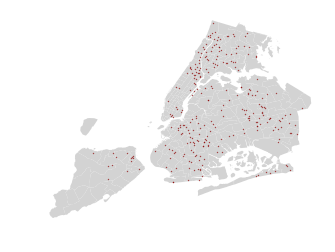

In [65]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_daycare.plot(ax=ax, markersize=0.1, color='darkred')
print(type(df_daycare))

In [66]:
#cemetery
df_cemetery=df_PoI[df_PoI.dum_cemetery!=0]
df_cemetery.reset_index(drop=True, inplace=True)

<class 'geopandas.geodataframe.GeoDataFrame'>


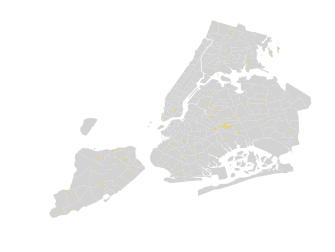

In [70]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df_cemetery.plot(ax=ax, markersize=0.1, color='gold')
print(type(df_cemetery))

In [71]:
# on utilise la base de données des taxi dispo sur le site de NYC
data = 'C:/Users/cleme/Documents/ENSAE/2A/S1/Python/Projet/Donnees/yellow_tripdata_2016-06.csv'

# !!! on prend un échantillon de 100 observations pour commencer
df = pd.read_csv(data, sep=',')
df.head()

#on ne garde que les courses payées en carte bleue pour avoir celles où le pourboire apparait
df = df[df.payment_type==1]
df = df[(df['pickup_longitude'] < -73.7) & (df['pickup_longitude'] > -74.1) & (df['pickup_latitude'] > 40.4) & (df['pickup_latitude'] < 51)]

df.reset_index(drop=True, inplace=True)


In [91]:
random.seed(35)
# assez lent, !!! on crée df0 = les 100 premières obs de la grosse base
df0 = df.sample(10000).reset_index()
#on crée un identifiant unique par course
df0['Id_course']= df0.index
df0.head()
df0['pts'] = gpd.GeoSeries([Point(xy) for xy in zip(df0.pickup_longitude, df0.pickup_latitude)])
df0['circles'] = gpd.GeoSeries(df0.pts).buffer(0.001)
df0=gpd.GeoDataFrame(df0).set_geometry('circles', crs = crs)

df0.head()

# le problème c'est qu'on a quelques valeurs très éloignées de la zone, il faut absolument les supprimer
# si on ne les supprime pas (essayer avec les 100 premières obs), le plot (les boroughs de NYC) et le subplot
# (les cercles qu'on a dessiné) ne sont plus tout à la même échelle
# = > on sélectionne les observations dont les pickup coordinates ne sortent pas de la zone de NYC


,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Id_course,pts,circles
0,5461356,2,2016-06-25 02:54:58,2016-06-25 03:00:53,1,1.60,-73.984619,40.728779,1,N,...,7.0,0.5,0.5,0.00,0.00,0.3,8.30,0,POINT (-73.984619140625 40.72877883911133),"POLYGON ((-73.983619140625 40.72877883911133, ..."
1,1897577,1,2016-06-06 14:10:00,2016-06-06 15:15:35,1,21.40,-73.783936,40.648579,2,N,...,52.0,0.0,0.5,5.00,5.54,0.3,63.34,1,POINT (-73.783935546875 40.64857864379883),"POLYGON ((-73.782935546875 40.64857864379883, ..."
2,5266140,1,2016-06-24 11:41:56,2016-06-24 12:13:33,1,13.50,-73.863274,40.769428,1,N,...,40.5,0.0,0.5,11.71,5.54,0.3,58.55,2,POINT (-73.86327362060547 40.76942825317383),POLYGON ((-73.86227362060546 40.76942825317383...
3,1237467,2,2016-06-05 10:49:07,2016-06-05 10:59:55,2,0.85,-73.974617,40.754150,1,N,...,7.0,0.0,0.5,2.20,0.00,0.3,10.00,3,POINT (-73.97461700439453 40.754150390625),"POLYGON ((-73.97361700439453 40.754150390625, ..."
4,5359581,2,2016-06-24 19:35:33,2016-06-24 20:03:49,6,3.65,-73.965759,40.770168,1,N,...,19.0,1.0,0.5,2.00,0.00,0.3,22.80,4,POINT (-73.96575927734375 40.77016830444336),POLYGON ((-73.96475927734375 40.77016830444336...


In [99]:
#on utilise une varaible indicatrice sur extra plutot que la chiffre
dummies = pd.get_dummies(df0['extra']!=0)
dummies.head()
df0['dum_extra']=dummies[True]
df0.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Id_course,pts,circles,dum_extra
0,5461356,2,2016-06-25 02:54:58,2016-06-25 03:00:53,1,1.60,-73.984619,40.728779,1,N,...,0.5,0.5,0.00,0.00,0.3,8.30,0,POINT (-73.984619140625 40.72877883911133),"POLYGON ((-73.983619140625 40.72877883911133, ...",1
1,1897577,1,2016-06-06 14:10:00,2016-06-06 15:15:35,1,21.40,-73.783936,40.648579,2,N,...,0.0,0.5,5.00,5.54,0.3,63.34,1,POINT (-73.783935546875 40.64857864379883),"POLYGON ((-73.782935546875 40.64857864379883, ...",0
2,5266140,1,2016-06-24 11:41:56,2016-06-24 12:13:33,1,13.50,-73.863274,40.769428,1,N,...,0.0,0.5,11.71,5.54,0.3,58.55,2,POINT (-73.86327362060547 40.76942825317383),POLYGON ((-73.86227362060546 40.76942825317383...,0
3,1237467,2,2016-06-05 10:49:07,2016-06-05 10:59:55,2,0.85,-73.974617,40.754150,1,N,...,0.0,0.5,2.20,0.00,0.3,10.00,3,POINT (-73.97461700439453 40.754150390625),"POLYGON ((-73.97361700439453 40.754150390625, ...",0
4,5359581,2,2016-06-24 19:35:33,2016-06-24 20:03:49,6,3.65,-73.965759,40.770168,1,N,...,1.0,0.5,2.00,0.00,0.3,22.80,4,POINT (-73.96575927734375 40.77016830444336),POLYGON ((-73.96475927734375 40.77016830444336...,1


<class 'geopandas.geodataframe.GeoDataFrame'>


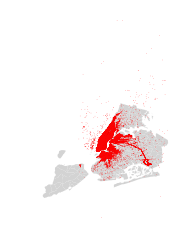

In [89]:
ax = df_taxizones.plot(color="lightgrey")
ax.set_axis_off()
df0.plot(ax=ax, markersize=0.01, color='red')
print(type(df0))

In [115]:
df0.tip_amount.describe()

count    10000.000000
mean         2.773899
std          2.791150
min          0.000000
25%          1.360000
50%          2.000000
75%          3.150000
max        109.700000
Name: tip_amount, dtype: float64

In [100]:
# college
nb_coll_circle = gpd.sjoin(df_college, df0.copy(),op='within')
count_coll = nb_coll_circle.groupby('Id_course').size()
count_coll.name="nb_college"

#subway entrances
nb_sub_circle = gpd.sjoin(df_subway, df0.copy(),op='within')
count_sub = nb_sub_circle.groupby('Id_course').size()
count_sub.name="nb_subway"


#hospitals
nb_hosp_circle = gpd.sjoin(geodf_hospital, df0.copy(),op='within')
count_hosp = nb_hosp_circle.groupby('Id_course').size()
count_hosp.name="nb_hospital"


#religion
nb_rel_circle = gpd.sjoin(df_religion, df0.copy(),op='within')
count_rel = nb_rel_circle.groupby('Id_course').size()
count_rel.name="nb_religion"

#consulate
nb_cons_circle = gpd.sjoin(df_consulate, df0.copy(),op='within')
count_cons = nb_cons_circle.groupby('Id_course').size()
count_cons.name="nb_consulate"

#park
nb_park_circle = gpd.sjoin(df_park, df0.copy(),op='within')
count_park = nb_park_circle.groupby('Id_course').size()
count_park.name="nb_park"

#theatre
nb_th_circle = gpd.sjoin(df_theatre, df0.copy(),op='within')
count_th = nb_th_circle.groupby('Id_course').size()
count_th.name="nb_theatre"

#school
nb_sc_circle = gpd.sjoin(df_school, df0.copy(),op='within')
count_sc = nb_sc_circle.groupby('Id_course').size()
count_sc.name="nb_school"

#library
nb_lib_circle = gpd.sjoin(df_library, df0.copy(),op='within')
count_lib = nb_lib_circle.groupby('Id_course').size()
count_lib.name="nb_library"

#daycare
nb_dc_circle = gpd.sjoin(df_daycare, df0.copy(),op='within')
count_dc = nb_dc_circle.groupby('Id_course').size()
count_dc.name="nb_daycare"

#cemetery
nb_cem_circle = gpd.sjoin(df_cemetery, df0.copy(),op='within')
count_cem = nb_cem_circle.groupby('Id_course').size()
count_cem.name="nb_cemetery"


df0_count = pd.concat([df0, count_coll,count_sub,count_hosp,count_rel,count_cons,count_park,count_th,count_sc,count_lib ,count_dc,count_cem], axis=1)
df0_count[['nb_college','nb_subway','nb_hospital','nb_religion','nb_consulate','nb_park','nb_theatre','nb_school','nb_library','nb_daycare','nb_cemetery']]=df0_count[['nb_college','nb_subway','nb_hospital','nb_religion','nb_consulate','nb_park','nb_theatre','nb_school','nb_library','nb_daycare','nb_cemetery']].fillna(0)

df0_count.head()
df0_count.columns


Index(['index', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'Id_course', 'pts', 'circles',
       'dum_extra', 'nb_college', 'nb_subway', 'nb_hospital', 'nb_religion',
       'nb_consulate', 'nb_park', 'nb_theatre', 'nb_school', 'nb_library',
       'nb_daycare', 'nb_cemetery'],
      dtype='object')

# On commence la régression !!!

In [113]:
# on divise en train et en test
f=df0_count.columns.get_loc("passenger_count")
i=df0_count.columns.get_loc("payment_type")
j=df0_count.columns.get_loc("fare_amount")
k=df0_count.columns.get_loc("dum_extra")

l=list(range(f,f+2))+list(range (i+1,j+1))+list(range(k,df0_count.shape[1]))

X, y = df0_count[df0_count.columns[l]], df0_count['tip_amount']

# On peut utiliser random_state=42 (par exemple) en option pour ne pas dependre du seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'dum_extra',
       'nb_college', 'nb_subway', 'nb_hospital', 'nb_religion', 'nb_consulate',
       'nb_park', 'nb_theatre', 'nb_school', 'nb_library', 'nb_daycare',
       'nb_cemetery'],
      dtype='object')

In [117]:
# On emprunte le code sur le site de scikit-learn et on l'adapte a notre probleme

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [  1.62761151e-02   4.23088285e-01   3.76074971e-02  -6.40719641e-02
  -5.93706076e-02  -3.25766809e-04  -1.62568325e-01  -3.81814013e-02
  -8.33736373e-04  -7.48363009e-02  -1.70141288e-02  -3.24419492e-02
   9.14257806e-02  -1.37033245e-01  -3.04741131e-01]
Mean squared error: 2.72
Variance score: 0.61


In [118]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
digit_knn=knn.fit(X_train, y_train)
# Estimation de l’erreur de prévision
# sur l’échantillon test
1-digit_knn.score(X_test,y_test)

ValueError: Unknown label type: 'continuous'